# Imports

In [42]:
# do general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time
import datetime
import warnings
warnings.filterwarnings("ignore")
import re

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import graphics
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape
from prophet import Prophet

# Loading Data

In [2]:
df = pd.read_csv('train_1.csv')
exog = pd.read_csv('Exog_Campaign_eng.csv')

In [3]:
df.shape

(145063, 551)

In [4]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
df.describe()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
count,1.243230e+05,1.242470e+05,1.245190e+05,1.244090e+05,1.244040e+05,1.245800e+05,1.243990e+05,1.247690e+05,1.248190e+05,1.247210e+05,...,1.412100e+05,1.414790e+05,1.418740e+05,1.413190e+05,1.411450e+05,1.413620e+05,1.412410e+05,1.412370e+05,1.414280e+05,1.415980e+05
mean,1.195857e+03,1.204004e+03,1.133676e+03,1.170437e+03,1.217769e+03,1.290273e+03,1.239137e+03,1.193092e+03,1.197992e+03,1.189651e+03,...,1.394096e+03,1.377482e+03,1.393099e+03,1.523740e+03,1.679607e+03,1.678302e+03,1.633966e+03,1.684308e+03,1.467943e+03,1.478282e+03
std,7.275352e+04,7.421515e+04,6.961022e+04,7.257351e+04,7.379612e+04,8.054448e+04,7.576288e+04,6.820002e+04,7.149717e+04,7.214536e+04,...,8.574880e+04,7.732794e+04,8.478533e+04,8.752210e+04,9.794534e+04,9.232482e+04,9.185831e+04,9.014266e+04,8.155481e+04,8.873567e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.300000e+01,1.300000e+01,1.200000e+01,1.300000e+01,1.400000e+01,1.100000e+01,1.300000e+01,1.300000e+01,1.400000e+01,1.400000e+01,...,2.200000e+01,2.200000e+01,2.000000e+01,2.100000e+01,2.200000e+01,2.300000e+01,2.400000e+01,2.300000e+01,2.300000e+01,2.100000e+01
50%,1.090000e+02,1.080000e+02,1.050000e+02,1.050000e+02,1.130000e+02,1.130000e+02,1.150000e+02,1.170000e+02,1.150000e+02,1.130000e+02,...,1.490000e+02,1.430000e+02,1.320000e+02,1.450000e+02,1.600000e+02,1.620000e+02,1.630000e+02,1.600000e+02,1.540000e+02,1.360000e+02
75%,5.240000e+02,5.190000e+02,5.040000e+02,4.870000e+02,5.400000e+02,5.550000e+02,5.510000e+02,5.540000e+02,5.490000e+02,5.450000e+02,...,6.070000e+02,5.980000e+02,5.690000e+02,6.280000e+02,6.590000e+02,6.680000e+02,6.540000e+02,6.490000e+02,6.350000e+02,5.610000e+02
max,2.038124e+07,2.075219e+07,1.957397e+07,2.043964e+07,2.077211e+07,2.254467e+07,2.121089e+07,1.910791e+07,1.999385e+07,2.020182e+07,...,2.420108e+07,2.253925e+07,2.505662e+07,2.586575e+07,2.834288e+07,2.691699e+07,2.702505e+07,2.607382e+07,2.436397e+07,2.614954e+07


In [6]:
exog.shape

(550, 1)

In [7]:
exog.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [8]:
exog.value_counts(dropna=False)

Exog
0       496
1        54
dtype: int64

# EDA

In [9]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


<AxesSubplot:>

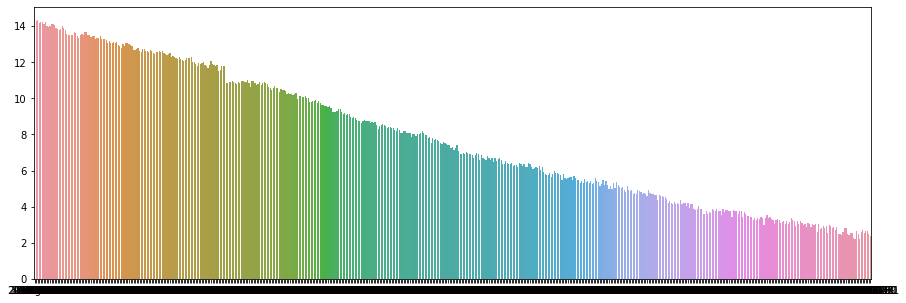

In [10]:
plt.figure(figsize=(15, 5))
null_rates = df.isna().mean() * 100
sns.barplot(null_rates.index, null_rates.values)

- There is clear linear trend in null rates, decreasing with time
- So most of the sites are being visited in Dec'16 (98%) as compared to Jul'15 (85%)

In [11]:
# Extrtacting data from page column

tmp = pd.DataFrame(df['Page'].str.split('_').str[-3:].tolist(), columns=['language', 'access_type', 'access_origin'])
df = pd.concat([df, tmp], axis=1)

df['language'] = df['language'].str.split('.').str[0]
df['title'] = df['Page'].apply(lambda x : re.findall(r'(.*)_\w+.wikipedia.org', x))

df['title'] = df['title'].apply(lambda x : x[0] if len(x) > 0 else np.nan)

df.drop(columns=['Page'], inplace=True)

---

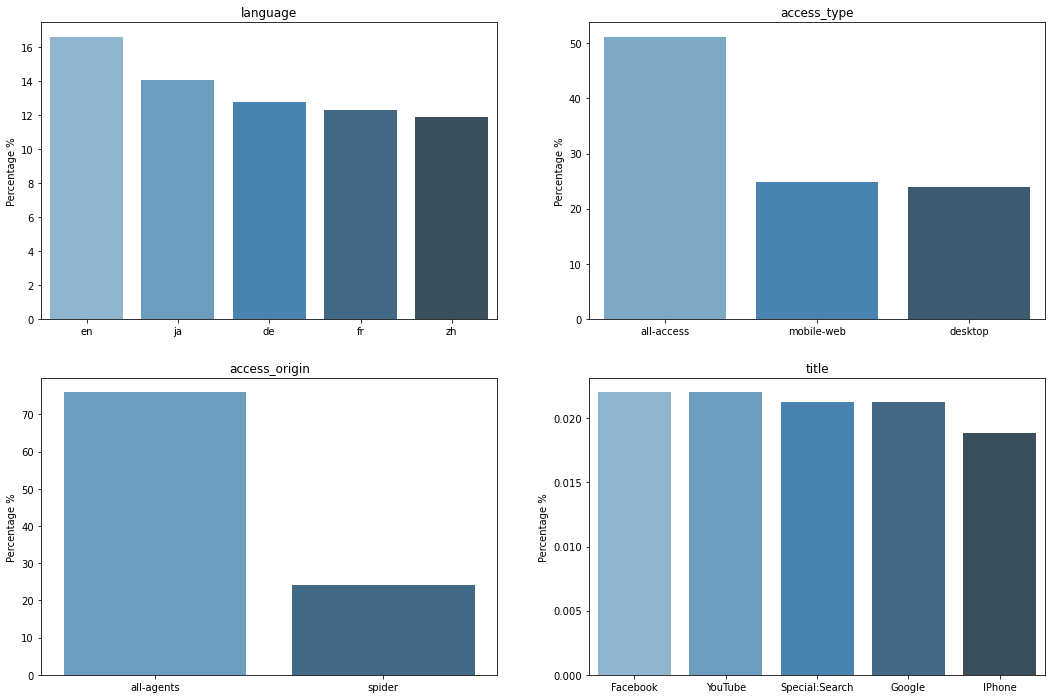

In [12]:
# Plot top 5 from each column in language, access_type, access_origin, title
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
for i, col in enumerate(['language', 'access_type', 'access_origin', 'title']):
    tmp = df[col].value_counts(1).head(5) * 100
    sns.barplot(tmp.index, tmp.values, ax=axes[i//2, i%2], palette='Blues_d')
    axes[i//2, i%2].set_title(col)
    axes[i//2, i%2].set_ylabel('Percentage %')


- English is the most popular language ~16%
- The most common type of access is all-access ~ 50%
- all-agents (~75%) is more common access origin than spider
- Top 5 web pages are : FB, YT, Special Search, Google, Iphone

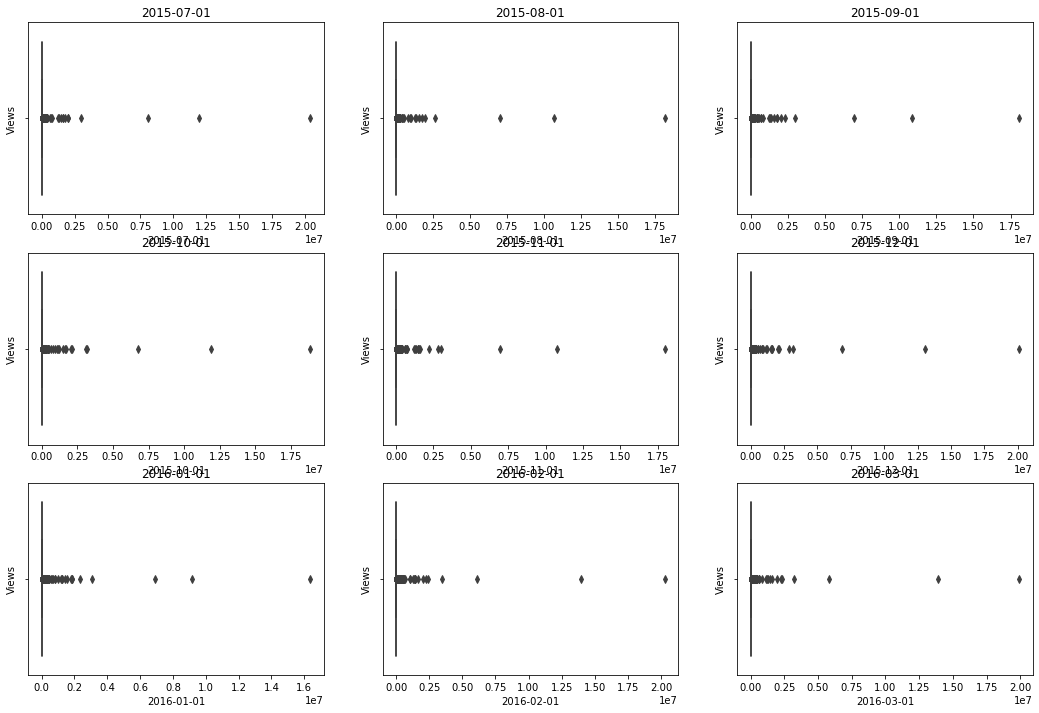

In [13]:
# plot boxplots for date_cols
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
for i, col in enumerate(['2015-07-01', '2015-08-01', '2015-09-01',
                        '2015-10-01', '2015-11-01', '2015-12-01',
                        '2016-01-01', '2016-02-01', '2016-03-01']):
    sns.boxplot(df[col], ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_ylabel('Views')

- The data has a lot of outliers. It would be better to take the median when grouping by language to tackle this issue

# Formatting Data for Model

In [14]:
date_cols = ([i for i in df.columns if i.startswith('20')])

In [15]:
df.shape

(145063, 554)

In [16]:
# Dropping rows which have all nulls
df = df.dropna(subset=date_cols, how='all', axis=0)

In [17]:
df.shape

(144411, 554)

In [18]:
# We will use linear interpolation to fill nulls as we saw that the nulls are linearly decreasing
df[date_cols] = df[date_cols].interpolate(method='linear', axis=1, limit_direction='both')

In [19]:
ts_data = df.groupby('language')[date_cols].median() # group by language and take median
# some processing of data
ts_data.index.name = ''
ts_data = ts_data.T.reset_index()
ts_data.rename(columns={'index':'date'}, inplace=True)
ts_data['date'] = pd.to_datetime(ts_data['date'], format='%Y-%m-%d')
ts_data.drop(columns=['commons','www'], inplace=True) # these are not languages

In [20]:
ts_data.shape

(550, 8)

In [21]:
ts_data.head()

,date,de,en,es,fr,ja,ru,zh
0,2015-07-01,87.5,165.0,287.0,85.0,167.0,157.0,70.0
1,2015-07-02,86.0,161.0,284.0,86.0,162.0,159.0,67.0
2,2015-07-03,85.0,151.0,255.0,85.0,171.0,158.0,66.0
3,2015-07-04,85.0,149.0,215.0,84.0,184.0,155.0,68.0
4,2015-07-05,97.5,157.0,254.0,93.0,183.0,164.0,70.0


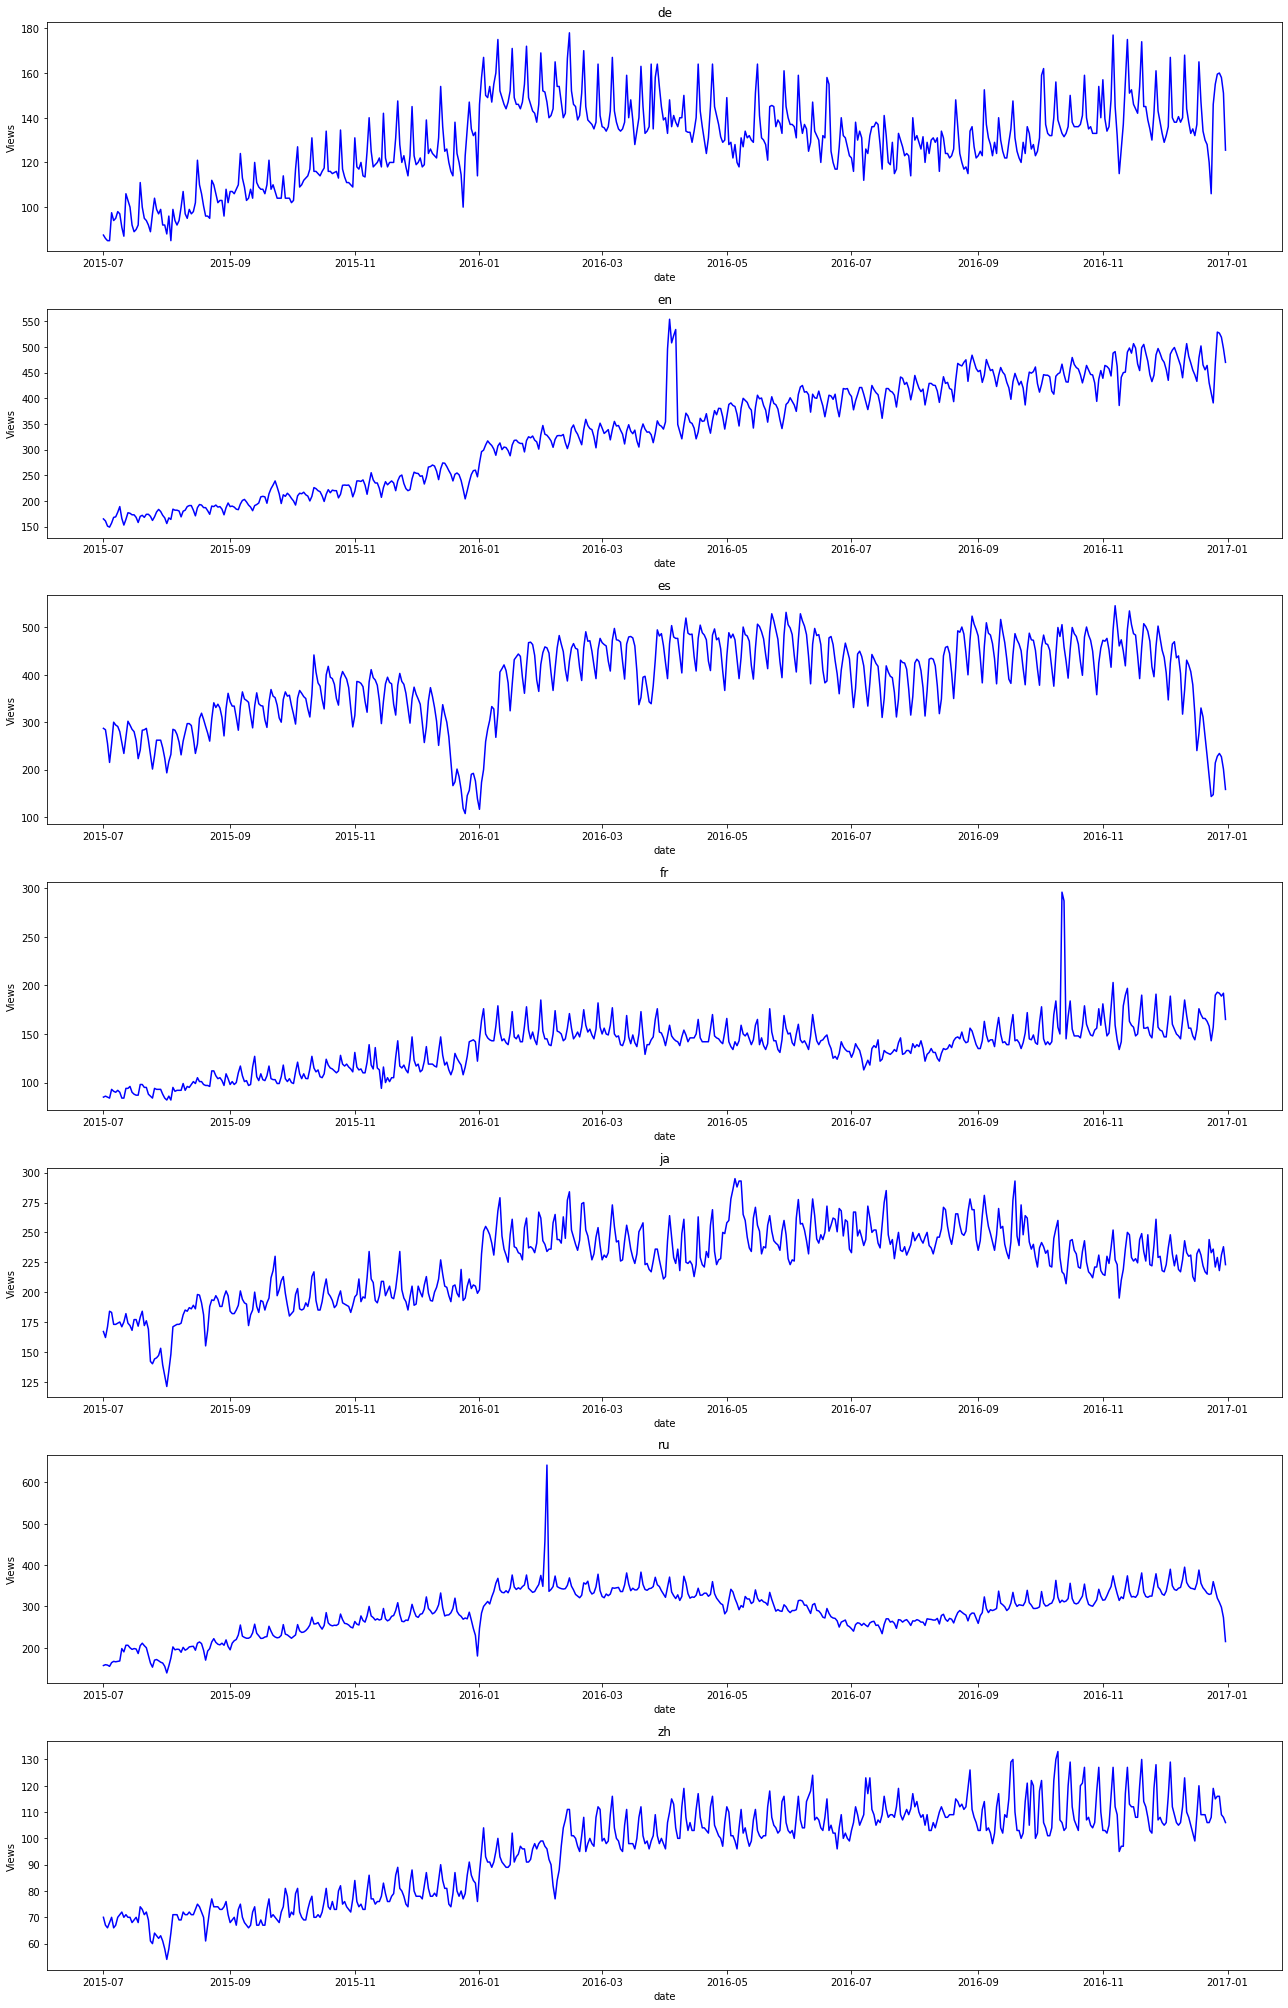

In [22]:
# plot line plot for each language
plt.rcParams['figure.autolayout'] = True
fig, axes = plt.subplots(7, 1, figsize=(18, 28))
for i, col in enumerate(ts_data.columns[1:]):
    sns.lineplot(x='date', y=col, data=ts_data, ax=axes[i], color='blue')
    axes[i].set_title(col)
    axes[i].set_ylabel('Views')

# Time Series Analysis for English

In [23]:
exog_present = True

In [24]:
views = ts_data[['date','en']].copy()
views.rename(columns={'en':'views'}, inplace=True)
views['stationary_views'] = views['views']
if exog_present:
    views['exog'] = exog['Exog']
views.head()

,date,views,stationary_views,exog
0,2015-07-01,165.0,165.0,0
1,2015-07-02,161.0,161.0,0
2,2015-07-03,151.0,151.0,0
3,2015-07-04,149.0,149.0,0
4,2015-07-05,157.0,157.0,0


In [25]:
def convert_to_stationary(df, diff_count=0, plot=True):
    p_value = adfuller(df['stationary_views'])[1]
    if p_value > 0.05:
        df['stationary_views'] = df['stationary_views'] - df['stationary_views'].shift(1)
        df.dropna(inplace=True)
        diff_count += 1
        return convert_to_stationary(df, diff_count, plot)
    else:
        print(f'\n\n***************** Stationary views obtained after {diff_count} differencing! ******************\n\n')
        if plot:
            fig,ax = plt.subplots(2,1, sharex=True, figsize=(8, 4))
            sns.lineplot(x='date', y='views', data=df, ax=ax[0])
            ax[0].set_title('Original views')
            sns.lineplot(x='date', y='stationary_views', data=df, ax=ax[1])
            ax[1].set_title('Stationary views')
        return df, diff_count



***************** Stationary views obtained after 1 differencing! ******************




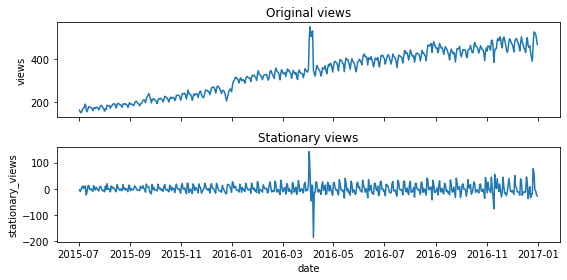

In [26]:
views, _ = convert_to_stationary(views)

In [27]:
views.head()

,date,views,stationary_views,exog
1,2015-07-02,161.0,-4.0,0
2,2015-07-03,151.0,-10.0,0
3,2015-07-04,149.0,-2.0,0
4,2015-07-05,157.0,8.0,0
5,2015-07-06,168.0,11.0,0


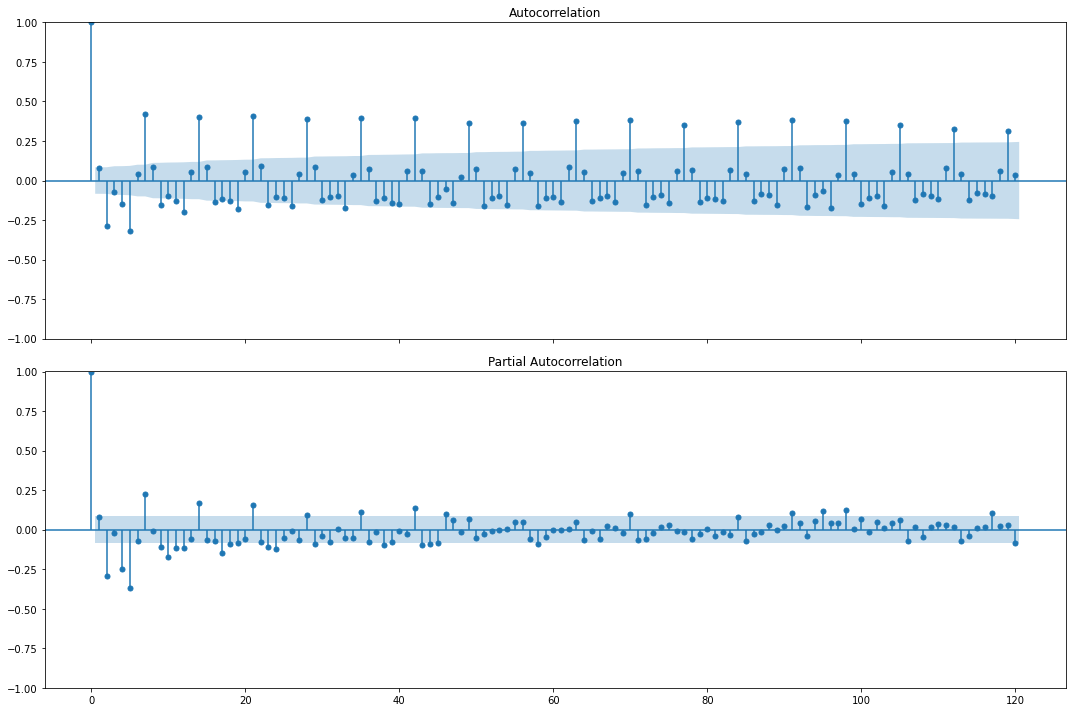

In [28]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(15, 10))
graphics.plot_acf(views['stationary_views'], lags=120, ax=ax[0])
graphics.plot_pacf(views['stationary_views'], lags=120, ax=ax[1])
plt.show()

- From acf plot we can see that there is weekly seasonality

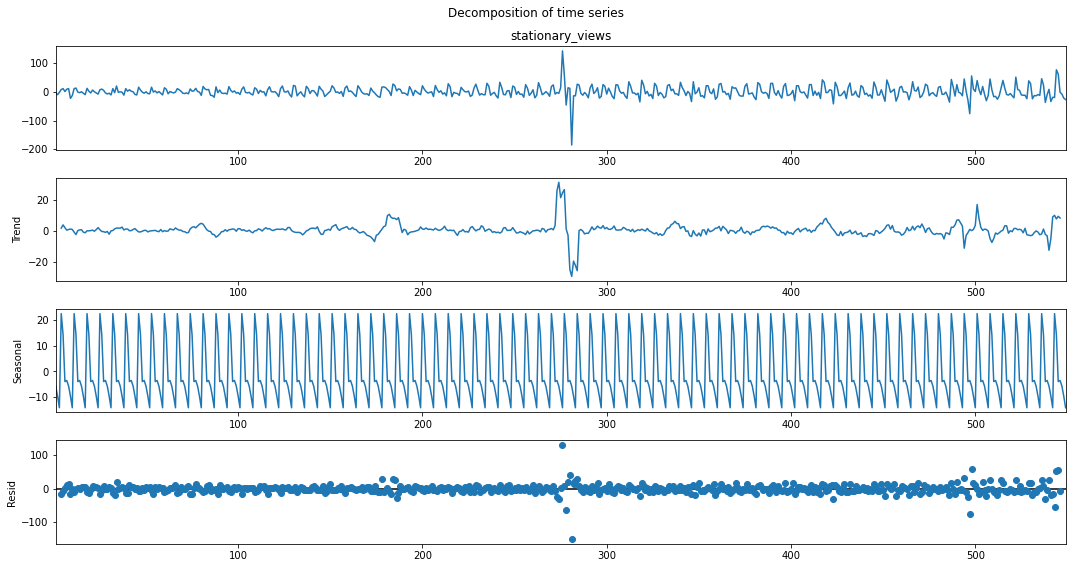

In [29]:
fig = seasonal_decompose(views['stationary_views'], model='additive', period=7).plot() 
fig.set_figheight(8)
fig.set_figwidth(15)
fig.suptitle('Decomposition of time series')
plt.show()

# Modelling

In [30]:
# Creating a function to print values of all these metrics.
def performance(actual, predicted):
    print('\n\n**************** Performance Metrics ****************\n')
    print('RMSE :', round(mse(actual, predicted)**0.5, 2)) 
    print('MAPE:', round(mape(actual, predicted)*100, 2),'%')

# train test split
def train_test_split(df, test_size=0.25):
    split_index = int(df.shape[0] * (1-test_size))
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train, test


In [31]:
train, test = train_test_split(views)

In [32]:
train.shape, test.shape

((411, 4), (138, 4))

In [38]:
def find_best_model(train_data, order_list, seasonal_order_list, exog_list):
    best_aic = np.inf
    for order in tqdm(order_list):
        for seasonal_order in seasonal_order_list:
            for exog_present in exog_list:
                SARIMAX_model = SARIMAX(train_data['views'], order=order, seasonal_order=seasonal_order, exog=train_data['exog'] if exog_present else None)
                SARIMAX_model_fit = SARIMAX_model.fit()
                if SARIMAX_model_fit.aic < best_aic:
                    best_aic = SARIMAX_model_fit.aic
                    best_order = order
                    best_seasonal_order = seasonal_order
                    best_exog = exog_present
    print(f'**************** Best model AIC is {best_aic} found with order {best_order} and seasonal order {best_seasonal_order} and exog {best_exog}******************\n')
    return best_order, best_seasonal_order, best_exog

def build_model_and_report(train_data, test_data, order=(0,0,0), seasonal_order=(0,0,0,0), exog_present=False):
    SARIMAX_model = SARIMAX(train_data['views'], order=order, seasonal_order=seasonal_order, exog=train_data['exog'] if exog_present else None)
    SARIMAX_model_fit = SARIMAX_model.fit()
    print(SARIMAX_model_fit.summary())
    preds = SARIMAX_model_fit.forecast(test_data.shape[0], exog=test_data['exog'] if exog_present else None)
    performance(test_data['views'], preds)
    plt.figure(figsize=(8,4))
    plt.title('Actual vs Predicted')
    sns.lineplot(x='date', y='views', data=train_data.tail(1000), label='Train')
    sns.lineplot(x='date', y='views', data=test_data, label='Test')
    sns.lineplot(x=test_data['date'], y=preds, label='Predicted')
    return

In [39]:
pdq = list(product(range(2), range(1,2), range(2))) # since we know differencing once is required
PDQS = list(product(range(2), range(2), range(2), [7])) # since we know seasonality is weekly
exog_list = [True, False] # checking with and without exog data

In [40]:
len(pdq), len(PDQS), len(exog_list)

(4, 8, 2)

- Searching for best parameters for SARIMAX model...

In [43]:
best_order, best_seasonal_order, best_exog = find_best_model(train, pdq, PDQS, exog_list)

100%|██████████| 4/4 [00:14<00:00,  3.73s/it]

**************** Best model AIC is 3330.1270838111077 found with order (1, 1, 1) and seasonal order (0, 1, 1, 7) and exog False******************



In [44]:
best_order, best_seasonal_order, best_exog

((1, 1, 1), (0, 1, 1, 7), False)

## Building best SARIMAX model

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  411
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 7)   Log Likelihood               -1661.064
Date:                           Wed, 05 Apr 2023   AIC                           3330.127
Time:                                   23:47:33   BIC                           3346.123
Sample:                                        0   HQIC                          3336.460
                                           - 411                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5186      0.219     -2.373      0.018      -0.947      -0.090
ma.L1          0.6542      0.191      3.416

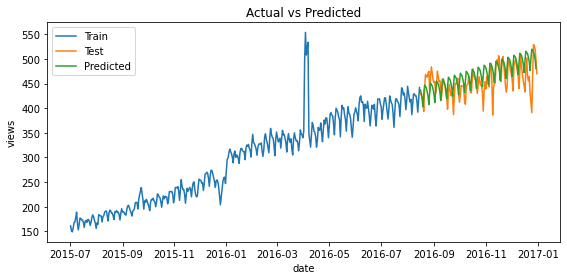

In [45]:
build_model_and_report(train, test, order=best_order, seasonal_order=best_seasonal_order, exog_present=best_exog)

## Training using prophet

In [46]:
m = Prophet()

In [47]:
m.fit(train[['date','views']].rename(columns={'date':'ds', 'views':'y'}))

23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing


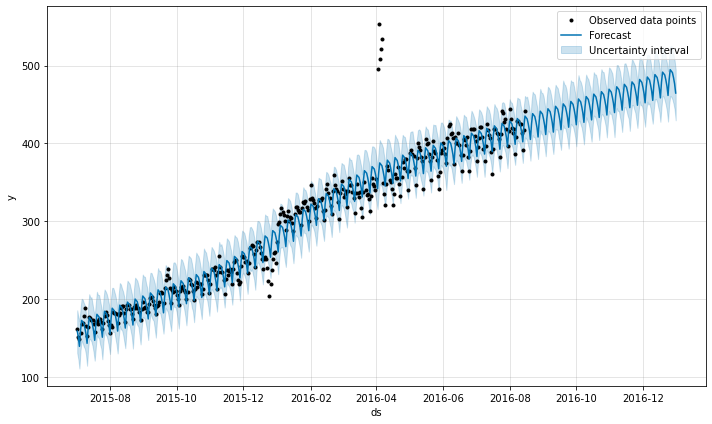

In [48]:
forecast = m.predict(m.make_future_dataframe(periods=test.shape[0]))
m.plot(forecast, include_legend=True);

In [49]:
performance(test['views'], forecast['yhat'].iloc[-test.shape[0]:])



**************** Performance Metrics ****************

RMSE : 21.99
MAPE: 3.67 %


## Running for other languages



*************** Language : de ***************




***************** Stationary views obtained after 1 differencing! ******************




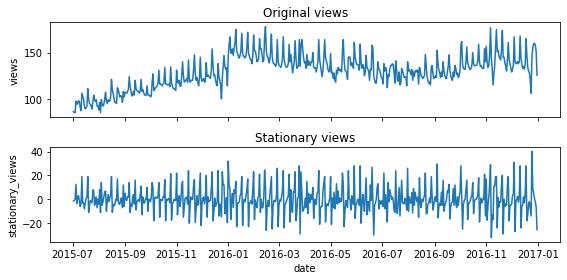

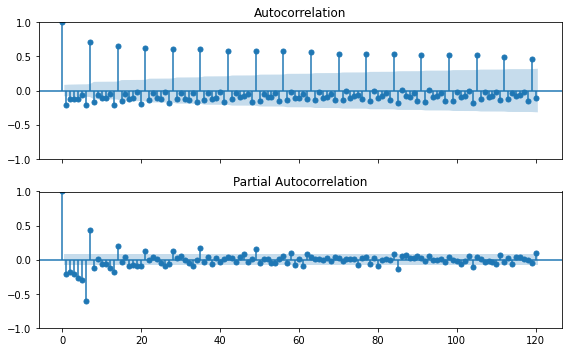

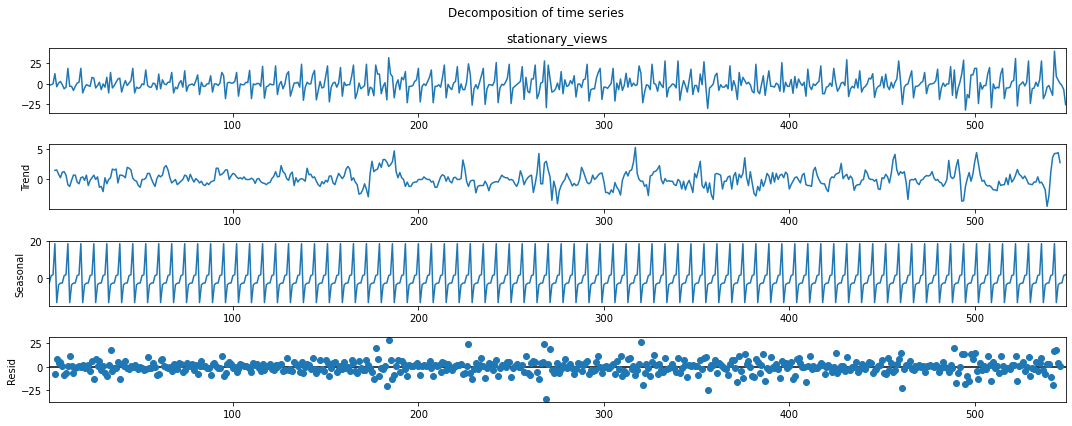

100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


**************** Best model AIC is 2647.0356865121207 found with order (1, 1, 1) and seasonal order (1, 0, 1, 7) and exog False******************

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  411
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1318.518
Date:                           Wed, 05 Apr 2023   AIC                           2647.036
Time:                                   23:47:48   BIC                           2667.116
Sample:                                        0   HQIC                          2654.980
                                           - 411                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

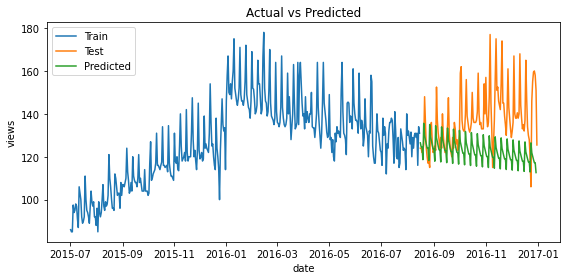

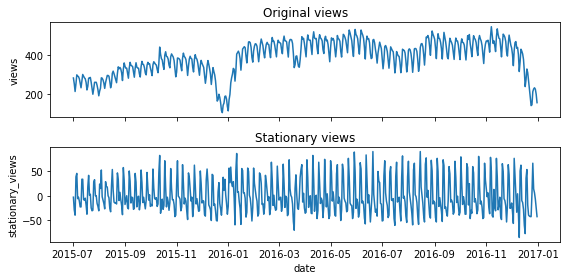

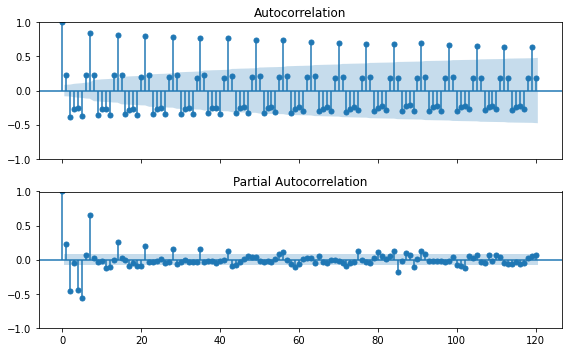

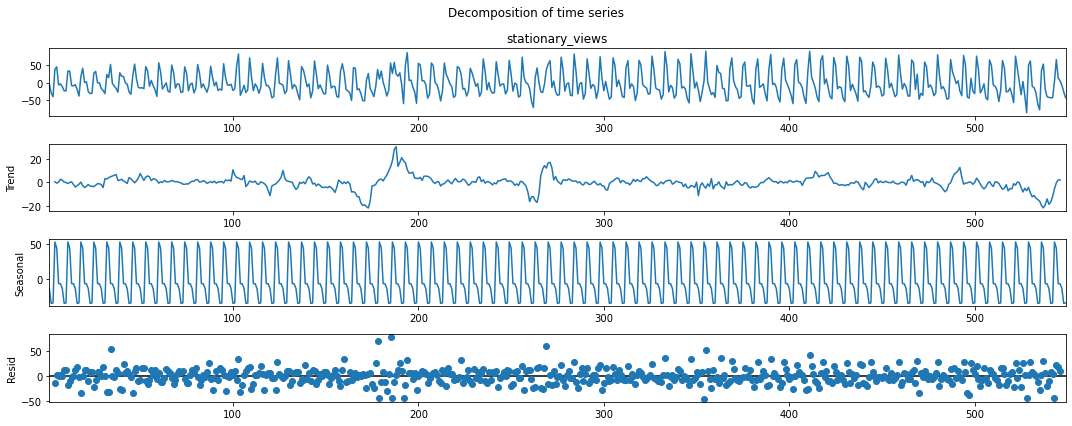

100%|██████████| 4/4 [00:02<00:00,  1.85it/s]


**************** Best model AIC is 3476.0251259879037 found with order (0, 1, 0) and seasonal order (1, 0, 1, 7) and exog False******************

                                      SARIMAX Results                                      
Dep. Variable:                               views   No. Observations:                  411
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood               -1735.013
Date:                             Wed, 05 Apr 2023   AIC                           3476.025
Time:                                     23:47:53   BIC                           3488.074
Sample:                                          0   HQIC                          3480.792
                                             - 411                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

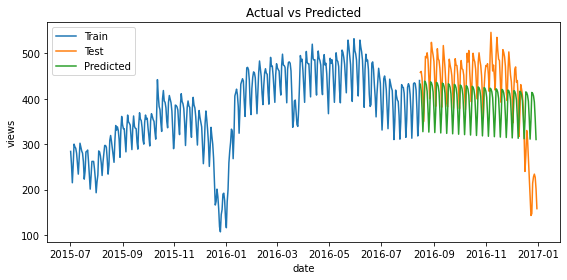

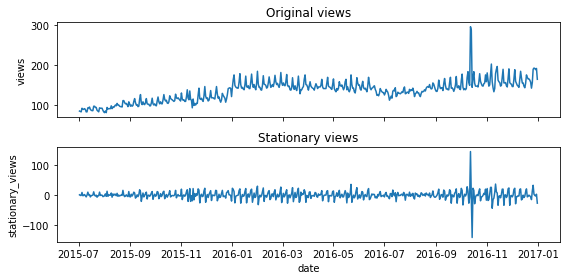

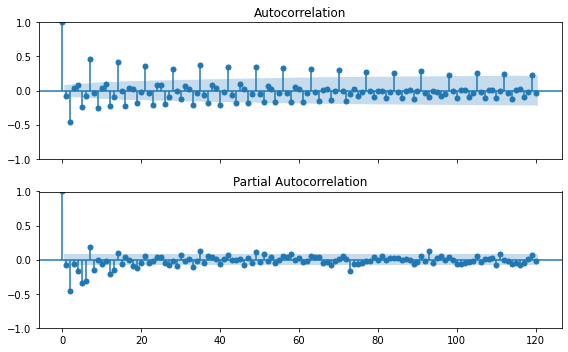

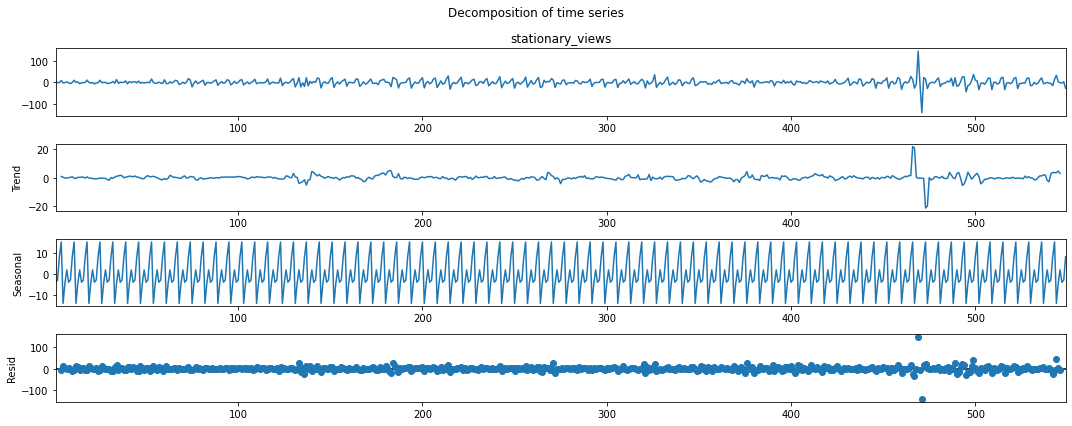

100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


**************** Best model AIC is 2640.2367273049176 found with order (1, 1, 1) and seasonal order (1, 0, 1, 7) and exog False******************

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  411
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1315.118
Date:                           Wed, 05 Apr 2023   AIC                           2640.237
Time:                                   23:47:58   BIC                           2660.318
Sample:                                        0   HQIC                          2648.181
                                           - 411                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

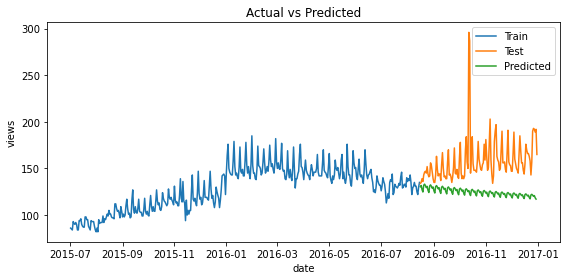

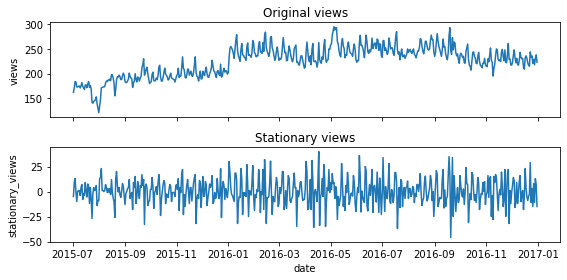

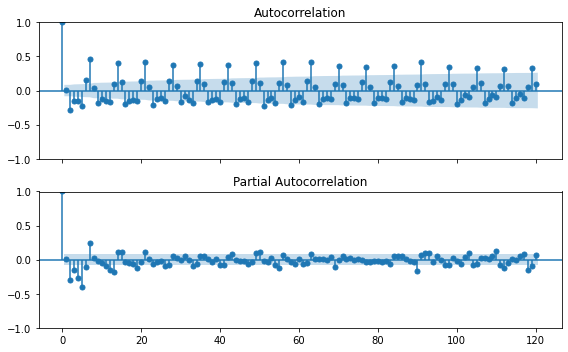

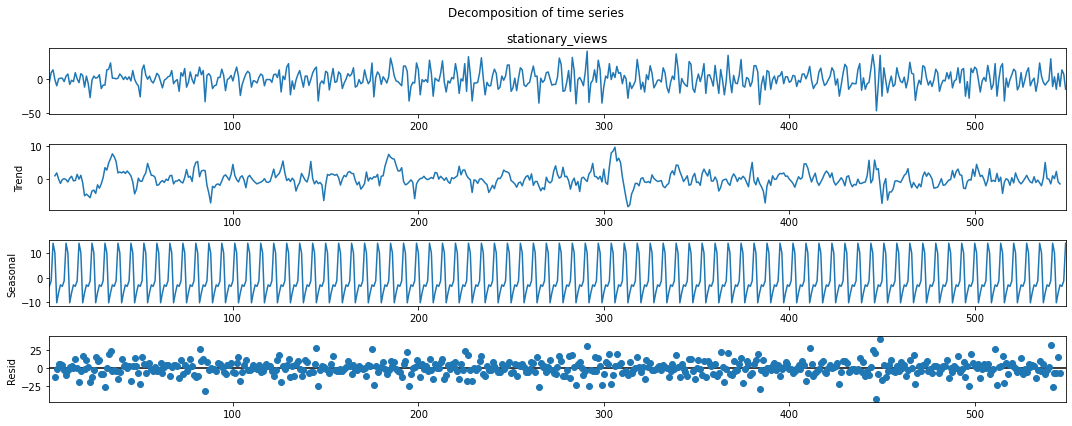

100%|██████████| 4/4 [00:03<00:00,  1.25it/s]


**************** Best model AIC is 3025.5207187681995 found with order (1, 1, 1) and seasonal order (1, 0, 1, 7) and exog False******************

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  411
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1507.760
Date:                           Wed, 05 Apr 2023   AIC                           3025.521
Time:                                   23:48:04   BIC                           3045.602
Sample:                                        0   HQIC                          3033.465
                                           - 411                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

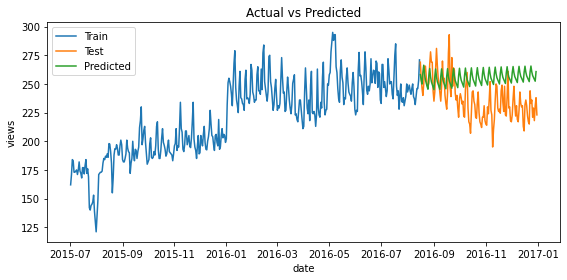

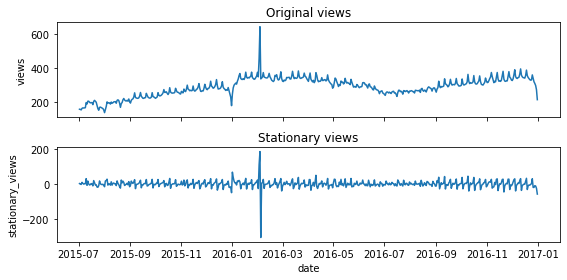

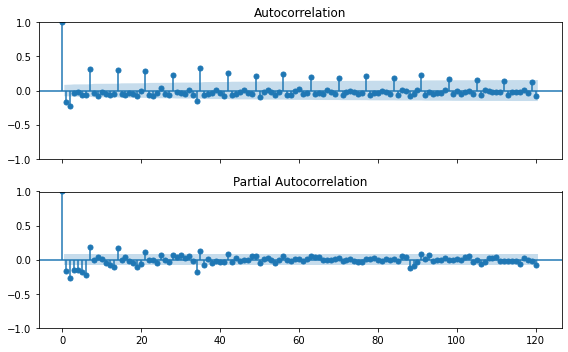

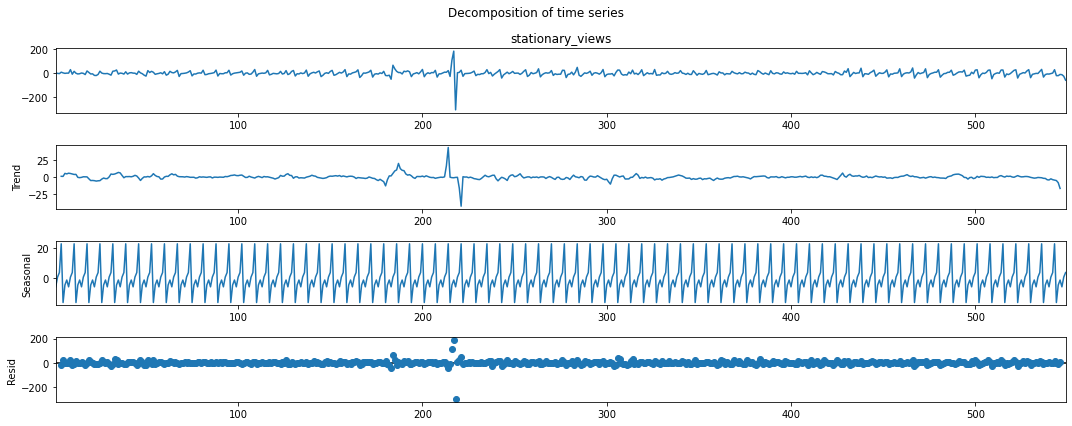

100%|██████████| 4/4 [00:03<00:00,  1.13it/s]


**************** Best model AIC is 3616.6536667150995 found with order (1, 1, 1) and seasonal order (1, 0, 1, 7) and exog False******************

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  411
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1803.327
Date:                           Wed, 05 Apr 2023   AIC                           3616.654
Time:                                   23:48:10   BIC                           3636.734
Sample:                                        0   HQIC                          3624.598
                                           - 411                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

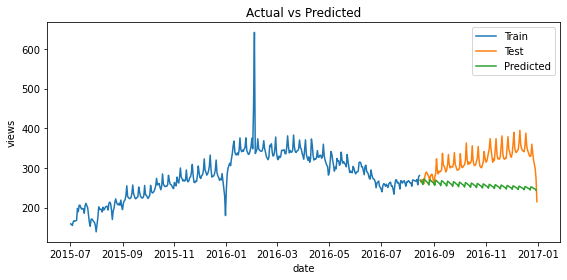

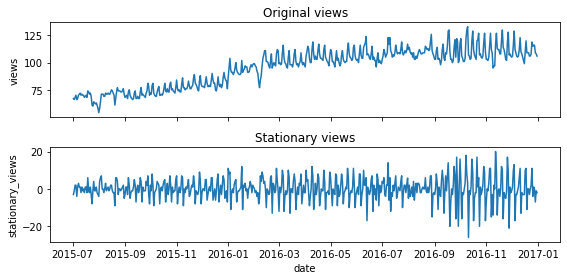

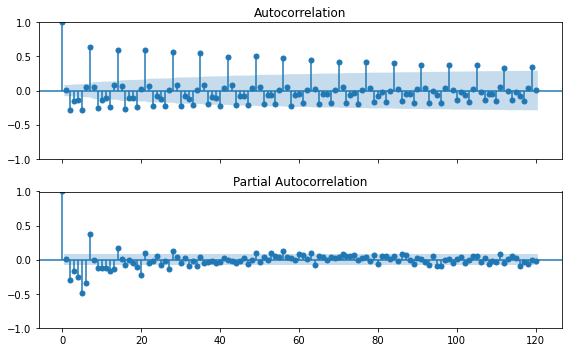

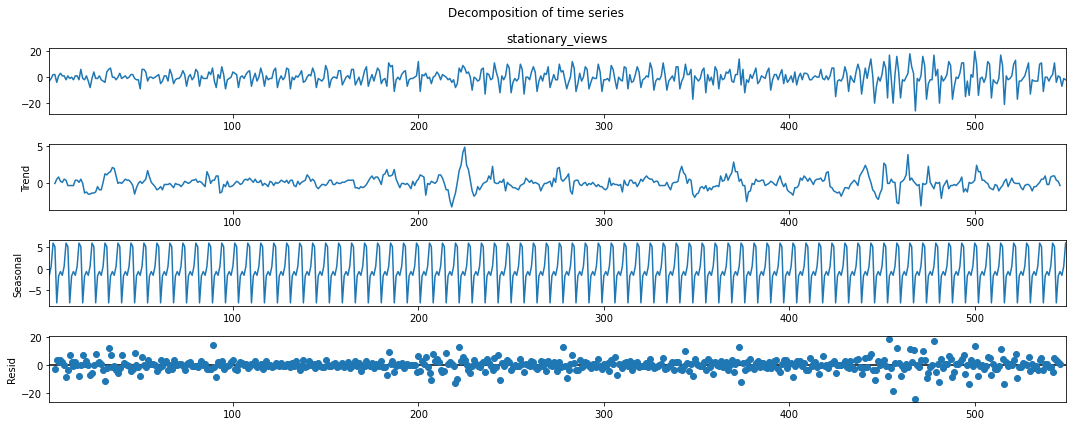

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


**************** Best model AIC is 2159.698775215993 found with order (1, 1, 1) and seasonal order (1, 0, 1, 7) and exog False******************

                                     SARIMAX Results                                     
Dep. Variable:                             views   No. Observations:                  411
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -1074.849
Date:                           Wed, 05 Apr 2023   AIC                           2159.699
Time:                                   23:48:14   BIC                           2179.780
Sample:                                        0   HQIC                          2167.643
                                           - 411                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

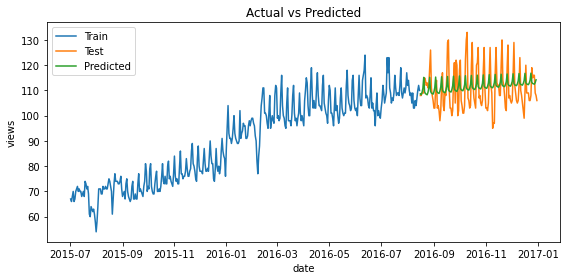

In [50]:
for lang in ['de','es','fr','ja','ru','zh']:
    print(f'\n\n*************** Language : {lang} ***************\n\n')
    views = ts_data[['date', lang]].copy()
    views.rename(columns={lang : 'views'}, inplace=True)
    views['stationary_views'] = views['views']
    
    views, diff_ = convert_to_stationary(views)    
    
    fig, ax = plt.subplots(2,1, sharex=True, figsize=(8, 5))
    graphics.plot_acf(views['stationary_views'], lags=120, ax=ax[0])
    graphics.plot_pacf(views['stationary_views'], lags=120, ax=ax[1])
    plt.show()
    
    fig = seasonal_decompose(views['stationary_views'], model='additive', period=7).plot() 
    fig.set_figheight(6)
    fig.set_figwidth(15)
    fig.suptitle('Decomposition of time series')
    plt.show()
    
    train, test = train_test_split(views)
    pdq = list(product(range(2), range(1,2), range(2))) # since we know differencing once is required
    PDQS = list(product(range(2), range(1), range(2), [7])) # since we know seasonality is weekly
    best_order, best_seasonal_order, _ = find_best_model(train, pdq, PDQS, [False])
    _ = build_model_and_report(train, test, order=best_order, seasonal_order=best_seasonal_order, exog_present=False)

## Questionnare

Defining the problem statements and where can this and modifications of this be used?


- We have to predict the number of views for a particular language for a particular day.
- We can modify the frequency of the data to be daily or weekly or monthly.

Write 3 inferences you made from the data visualizations

- English is the most popular language ~16%
- The most common type of access is all-access ~ 50%
- all-agents (~75%) is more common access origin than spider
- Top 5 web pages are : FB, YT, Special Search, Google, Iphone

What does the decomposition of series do?


- Decomposition breaks a time series into trend, seasonality and noise

What level of differencing gave you a stationary series?


- Difference -> 1

Difference between arima, sarima & sarimax

- Sarima includes seasonality for AR and MA methods
- Sarimax can include exogenous variables

Compare the number of views in different languages

In [57]:
ts_data.mean()


de    129.270909
en    336.082915
es    387.381480
fr    135.845036
ja    224.789091
ru    288.667829
zh     95.338874
dtype: float64








What other methods other than grid search would be suitable to get the model for all languages?

- We can use grid search or use auto arima